<a href="https://colab.research.google.com/github/brontide/Colab/blob/main/gasmeter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using OpenCV to read a household gas meter (Part 1)
 
In this notebook I will go over the steps I used to monitor my gas meters using python and OpenCV.  This notebook was written on Google CoLab and you should be able to run it interactvely there.  

We will walk through the basics.
 
1. Detecting where the dials are on the image
1. Detecting where the hands are on the dial
1. Sorting the dials so that we can "read" them properly
1. Extracting numeric values from the dials
  
This is my first work with OpenCV and numpy so there are likely some things that could be improved upon.

Inspired by the work of [Analog Gauge Reader from the Intel-IOT-DevKit](https://github.com/intel-iot-devkit/python-cv-samples/tree/master/examples/analog-gauge-reader).  We deviate signifigantly on hand detection as I was unable to get the readings to be accurate.

# Imports and download samples

In [1]:
# let's load our libraies
import cv2
import numpy as np
from math import cos, sin, radians, floor, ceil
import time
from google.colab.patches import cv2_imshow
from pprint import pprint

In [2]:
# Download some sample images
!pip install wget
import wget
import os.path

samples = [
           ["https://github.com/brontide/Gas-Meter-Notebook/blob/main/images/sample-0.jpg?raw=true", 'sample-0.jpg'],
           ["https://github.com/brontide/Gas-Meter-Notebook/blob/main/images/sample-1.jpg?raw=true", 'sample-1.jpg'],
]

for sample in samples:
  if not os.path.exists(sample[1]):
    print(f"Downloading {sample[0]}")
    wget.download(*sample)
  else:
    print(f"already downloaded {sample[1]}")


  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=3d0a8b393184bfbfdd955517ca41af8ae39d03f8f4d7bc778d5506fdd2cb1a8c
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


# Load sample image

In this section we will load the sample image and extract a region for analysis.

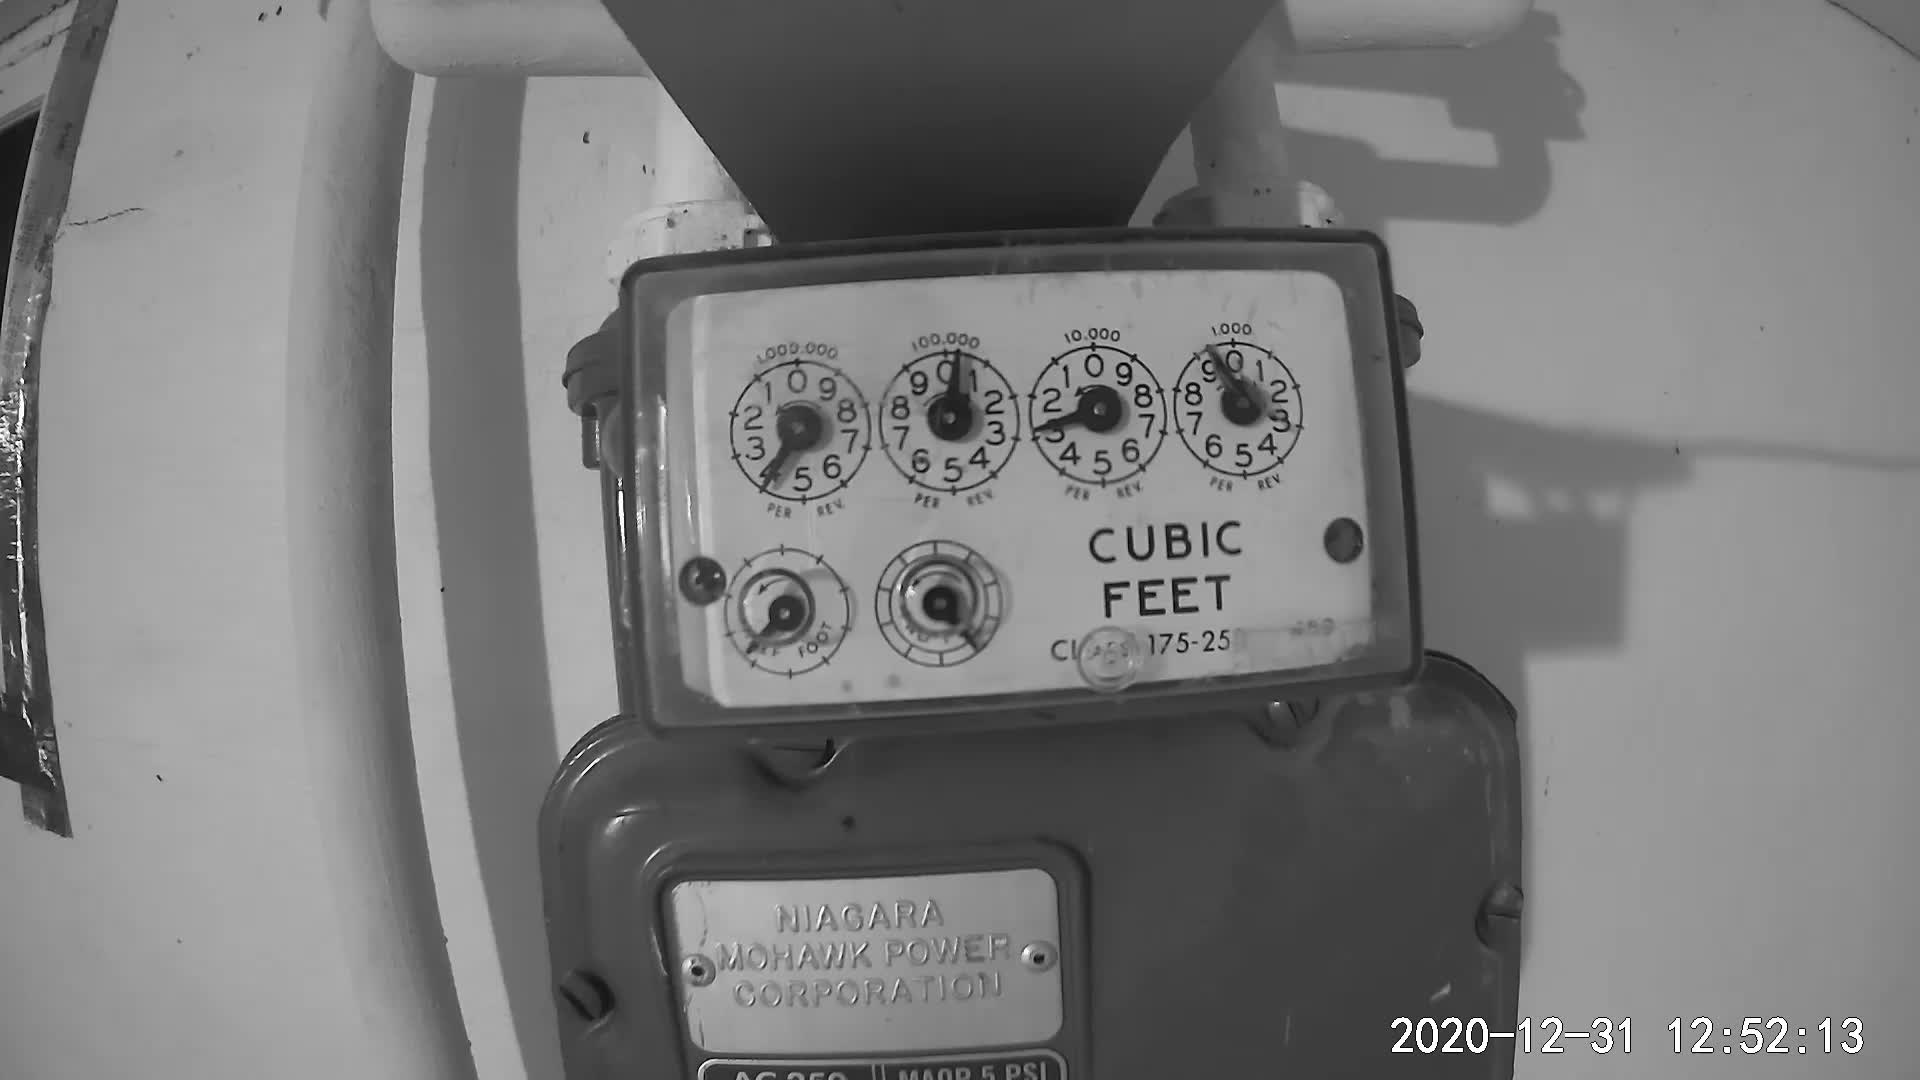

In [3]:

# load the image in grayscale
img = cv2.imread('sample-1.jpg',0)

cv2_imshow(img)

First let's set up a region of interest (ROI) within the image.  OpenCV allows you to reduce an image but the syntax is weird, since it's based on numpy arrays, given x2,y2 -> x2,y2 you would use the following to crop.

```python3
out_img = in_img[y1:y2, x1:x2]
```

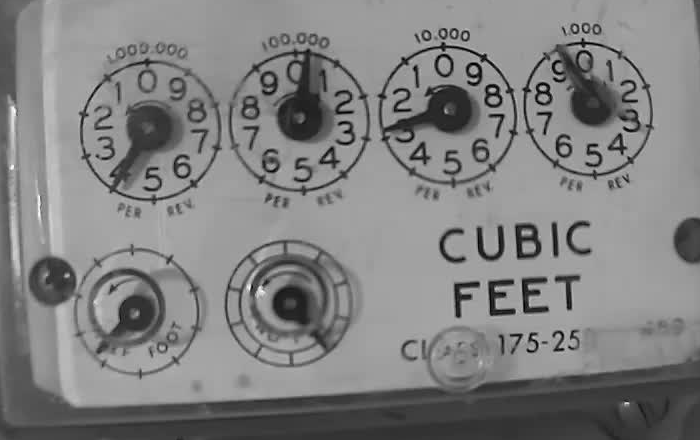

In [4]:
# Cropped image

crop = img[300:740,650:1350]

cv2_imshow(crop)

# Detection of dials

For the detection of dials we will use the HoughCircles algorithm. It will output an array oy x,y,r of all detected circles.  Frankly this part of the process was a lot easier than I expected.  Changing the variables can have a strong effect on the output, here are some of the important variables and their effect on the results.


* minRadius = minimum radius to detect a circle
* maxRadius = maximum radius to detect a circle
* param2 = "votes" reduce this if it's having trouble seeing circles, increase it if it's finding phantom circles

In [5]:
circles = cv2.HoughCircles(crop, cv2.cv2.HOUGH_GRADIENT,1.5,80,
                            param1=50,param2=100,minRadius=50,maxRadius=80)
circles


array([[[446.25, 116.25,  67.55],
        [150.75, 131.25,  70.85],
        [300.75, 120.75,  69.2 ],
        [135.75, 312.75,  62.6 ],
        [290.25, 303.75,  63.2 ],
        [591.75, 114.75,  60.95]]], dtype=float32)

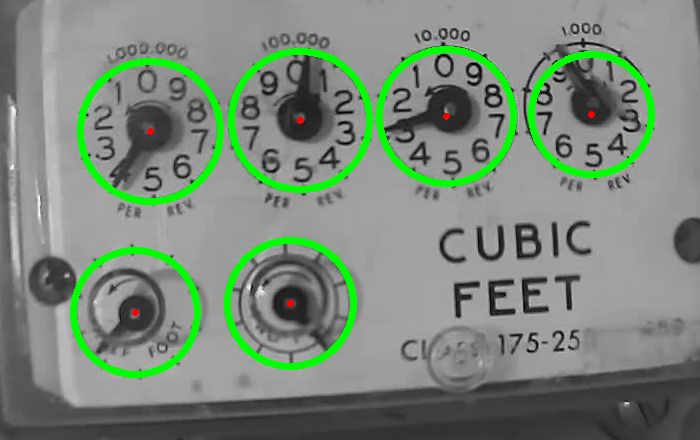

In [6]:
def debugImage(img, circles):
  # Let's make the debug image color from grayscale so we can use color in
  # debugging diagrams
  debug = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

  for circle in circles[0,:]: # iterating over numpy array
    (x,y,r) = circle[0:3]
    cv2.circle(debug, (x,y), r, (0,255,0), 5)
    cv2.circle(debug, (x,y), 2, (0,0,255), 2)

  return debug

debug = debugImage(crop, circles)
cv2_imshow(debug)

# Detecting the hands on the dials

The next step is detecting the hands of dials but this ended up being a little more beguiling than expected.  Some other code snippets used Hough Lines, but that was a dead-end as there was far too much noise in the dial for that to be successful.  The direction that ended up working for me was converting to polar and then summing the lines to detect the "most dark line" ( minimum value in array ).

446 116 67


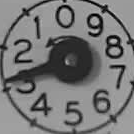

In [7]:
# let's grab one dial
circle = circles[0,:1]

# Croping requires ints
(x,y,r) = circle[0]
x = int(x)
y = int(y)
r = int(r)

print(x,y,r)
dial = crop[y-r:y+r,x-r:x+r]

cv2_imshow(dial)

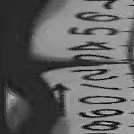

Smallest row is 63 out of 134


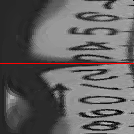

In [12]:
# convert to polar
warp = cv2.linearPolar(dial, (r,r), r, cv2.WARP_FILL_OUTLIERS)
dial_debug = cv2.cvtColor(warp, cv2.COLOR_GRAY2BGR)

cv2_imshow(warp)

# Sum the rows ( horizontal )
rowSums = np.sum(warp,axis=1)
# Find the row with the smallest value ( darkest )
smallest = np.argmin(rowSums)

print(f"Smallest row is {smallest} out of {r*2}")

cv2.line(dial_debug, (0,smallest),(r*2,smallest),(0,0,255),1)

cv2_imshow(dial_debug)

Given the row we can then convert that to an angle and then apply it back to the debugging image to see just how accurate this simple transformation is.

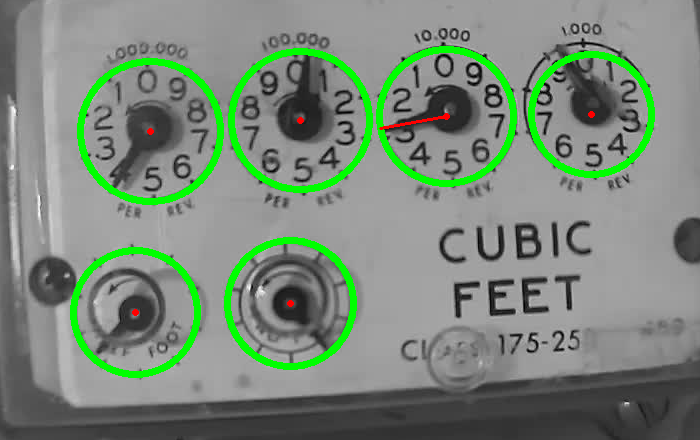

In [9]:
# note 0 is 3 o'clock
angle = (smallest/(r*2))*360

# let's overlay this on the debug
x2 = x + ( r * cos(radians(angle)) )
y2 = y + ( r * sin(radians(angle)) )

cv2.line(debug, (x,y), (int(x2),int(y2)), (0,0,255), 2)
cv2_imshow(debug)

# Ordering dials for proper reading
 
As seen above circles aren't returned in any predictable order so we're going to have to come up with a way of ordering the circles.  For the numpy purists there is likely a better way to do this but I'm going to take the data out of numpy to do this work.  Let's also turn our hand reading into a function.
 
The basics of this is to use a custom sort to return a tuple of row, column.  Python sort will do the rest sorting it by the first and then by the second.


In [10]:
#
# Make the extraction of the angle a function
#
def dial_to_angle(img, x, y, r):
  # pull the dial from the image
  x=int(x)
  y=int(y)
  r=int(r)
  dial = img[y-r:y+r,x-r:x+r]
  # polar warp
  warp = cv2.linearPolar(dial, (r,r), r, cv2.WARP_FILL_OUTLIERS)
  # Sum the rows ( horizontal )
  rowSums = np.sum(warp,axis=1)
  # Find the smallest row ( darkest )
  smallest = np.argmin(rowSums)
  # to angle, but 0 is 3'oclock ( 2.5 )
  angle = (360*smallest)/(r*2)
  angle += 90
  if angle >= 360:
    angle -= 360
  return angle

def order_circles(circles, split):
  results = []
  for circle in circles[0,:]:
    x = circle[0]
    y = circle[1]
    r = circle[2]
    results.append({'x': x, 'y': y, 'r': r})

  # rather than a lambda lets do a function
  def mysort(cir):
    if cir['y']<split:
      # Top row = 0
      return (0,cir['x'])
    else:
      # Bottom row = 1
      return (1,cir['x'])

  results.sort(key=mysort)
  return results

# split the rows to upper and lower half of the
# image
results = order_circles(circles,crop.shape[0]/2)
for res in results:
  res['angle'] = dial_to_angle(crop, **res)

pprint(circles)
pprint(results)


array([[[446.25, 116.25,  67.55],
        [150.75, 131.25,  70.85],
        [300.75, 120.75,  69.2 ],
        [135.75, 312.75,  62.6 ],
        [290.25, 303.75,  63.2 ],
        [591.75, 114.75,  60.95]]], dtype=float32)
[{'angle': 213.42857142857144, 'r': 70.85, 'x': 150.75, 'y': 131.25},
 {'angle': 6.52173913043481, 'r': 69.2, 'x': 300.75, 'y': 120.75},
 {'angle': 259.25373134328356, 'r': 67.55, 'x': 446.25, 'y': 116.25},
 {'angle': 345.0, 'r': 60.95, 'x': 591.75, 'y': 114.75},
 {'angle': 223.5483870967742, 'r': 62.6, 'x': 135.75, 'y': 312.75},
 {'angle': 141.42857142857144, 'r': 63.2, 'x': 290.25, 'y': 303.75}]


# Extract digits from each dial

Let's take a look at the readings from each dial now.  We have to be aware that some of the dials are read clockwise and some are read counterclockwise.  Thankfully the ordering and direction of each dial seems to be an industry standard.

In [11]:
#
# given 0-360, clockwise, and maximum value of the dial 
# return the decimal value.
#
def angle_to_digit(angle, cw=False, out_of=10):
  # cw = True for clockwise / False for CCW
  if not cw:
    angle = 360-angle
  return angle/(360/out_of)

# Constants
dial_orientation = [ False, True, False, True, False, False ] # CCW, CW, CCW, CW, CCW, CCW
dial_range = [ 10, 10, 10, 10, .5, 2 ]
# End Constants

for i, res in enumerate(results):
  res['digit'] = angle_to_digit(res['angle'], cw=dial_orientation[i], out_of=dial_range[i])

pprint(['{:.2f}'.format(x['digit']) for x in results])

['4.07', '0.18', '2.80', '9.58', '0.19', '1.21']


# End

The next write-up will be extending this work to read from a video stream and will cover the additional topics of.
 
1. Reading from a Capture Device ( rtsp or video file )
1. Dealing with errors in reading
1. Stabilizing the readings
1. Smarter reading of dials.
